# Comparison: by-hand -vs- built-in Gaussian random walk

Compare the built-in GaussianRandomWalk() with a model that achieves the same result without using the built-in.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Fake-up-some-noisy-data" data-toc-modified-id="Fake-up-some-noisy-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fake up some noisy data</a></span></li><li><span><a href="#Hand-coded-Random-Walk" data-toc-modified-id="Hand-coded-Random-Walk-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hand-coded Random Walk</a></span></li><li><span><a href="#Hand-coded-random-walk,-but-with-fewer-priors,-more-fixed-parameters" data-toc-modified-id="Hand-coded-random-walk,-but-with-fewer-priors,-more-fixed-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hand-coded random walk, but with fewer priors, more fixed parameters</a></span></li><li><span><a href="#Using-the-built-in-Gaussian-Random-Walk" data-toc-modified-id="Using-the-built-in-Gaussian-Random-Walk-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Using the built-in Gaussian Random Walk</a></span></li><li><span><a href="#Built-in-GRW---with-a-cut-down-model" data-toc-modified-id="Built-in-GRW---with-a-cut-down-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Built-in GRW - with a cut down model</a></span></li><li><span><a href="#Comparison-plot" data-toc-modified-id="Comparison-plot-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparison plot</a></span></li><li><span><a href="#Observations" data-toc-modified-id="Observations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Observations</a></span></li></ul></div>

## Python setup

In [1]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
import theano
import theano.tensor as tt
import pymc3 as pm

In [2]:
# Globals
NOISE_SD = 0.3
INNOVATION = 0.15
STUDENT_T_DF = 4 # degrees of freedom - fat tails

In [3]:
# supporting functions
def plot_trace(trace, title):
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.scatter(x, y, s=10)
    data = trace.posterior.stack(draws=("chain", "draw"))['walk'].values.T.mean(axis=0)
    ax.plot(x, data, c='red')
    ax.set_title(title)
    plt.show()
    plt.close()
    return data

In [4]:
# supporting functions
def do_model(model, description, compare):
    display(pm.model_to_graphviz(model))
    with model:
        trace = pm.sample(1000, tune=5000, return_inferencedata=True)
    az.plot_trace(trace)
    compare[description] = plot_trace(trace, 'Estimated')

## Fake up some noisy data

Note: using student_t for the noise, with a small number of degrees of freedom - for the fat tails.

In [5]:
n = 100
x = np.linspace(0, 2 * np.pi, n) 
actual = np.sin(x) * 2.5
y = actual + np.random.standard_t(df=STUDENT_T_DF, size=n) / 3
print(len(y))

100


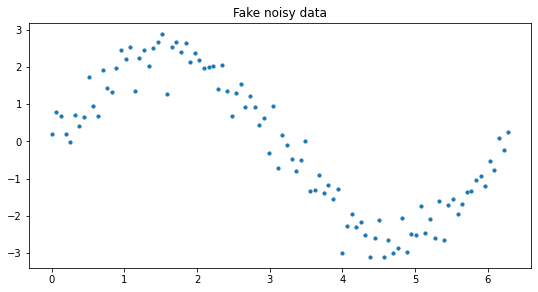

In [6]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.scatter(x, y, s=10)
ax.set_title('Fake noisy data')
plt.show()
plt.close()

## Hand-coded Random Walk

***Key insight***: a random walk comprises the cumulative sum of a starting point, following by a series of incremental changes; where all of the incremental changes are distributed normally around a mean of zero and a standard-deviation parameter for step-on-step innovation. 

In [7]:
m1 = pm.Model()
with m1:
    # priors
    start = pm.Cauchy('start', alpha=0, beta=1, shape=(1, 1)) # force scalar as a tensor
    innovation = pm.HalfNormal('innovation', sigma=1)
    add_step = pm.Normal('add_step', mu=0, sd=innovation, shape=(len(y)-1))
    walk = pm.Deterministic( 
        'walk', 
        pm.math.concatenate([start[0,], add_step], axis=0).cumsum() 
    )
    sigma = pm.HalfNormal('sigma', sigma=NOISE_SD)
    nu = pm.Poisson('nu', mu=STUDENT_T_DF)
    
    # likelihood (measurement model with fat-tail noise) - use student's t distribution
    obs = pm.StudentT('obs', mu=walk, nu=nu, sigma=sigma, observed=y)

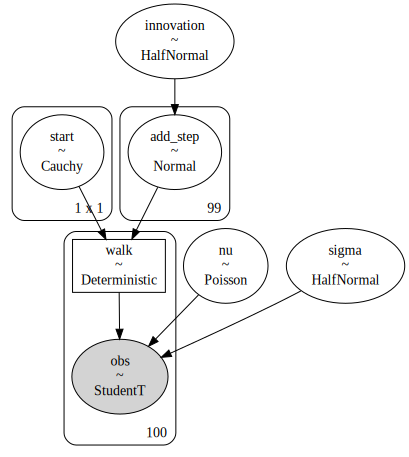

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, add_step, innovation, start]
>Metropolis: [nu]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 111 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


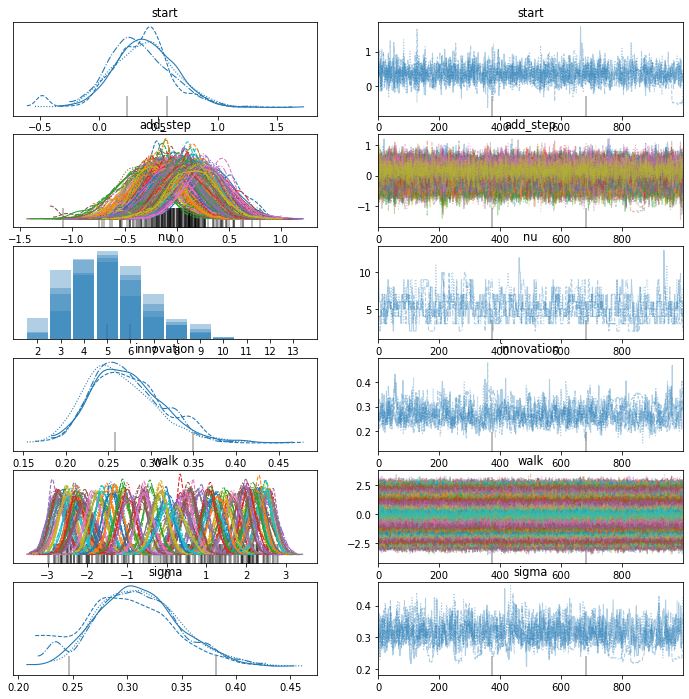

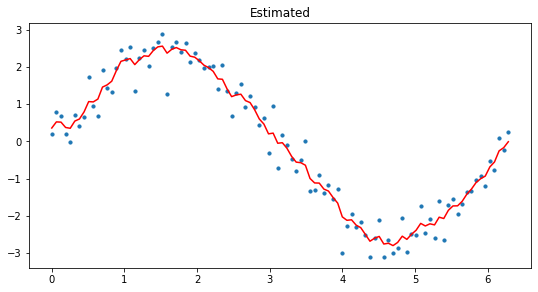

In [8]:
compare = {}
do_model(m1, 'Hand coded - full version', compare)

## Hand-coded random walk, but with fewer priors, more fixed parameters

In [9]:
m3 = pm.Model()
with m3:
    # priors
    start = pm.Cauchy('start', alpha=0, beta=1, shape=(1, 1)) # force scalar as a tensor
    add_step = pm.Normal('add_step', mu=0, sd=INNOVATION, shape=(len(y)-1))
    walk = pm.Deterministic( 
        'walk', 
        pm.math.concatenate([start[0,], add_step], axis=0).cumsum() 
    )
  
    # likelihood (measurement model with fat-tail noise) - use student's t distribution
    obs = pm.StudentT('obs', mu=walk, nu=STUDENT_T_DF, sigma=NOISE_SD, observed=y)

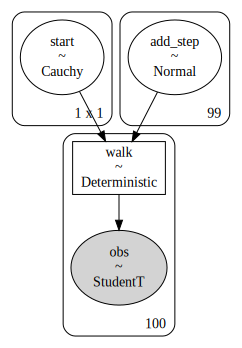

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [add_step, start]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 55 seconds.


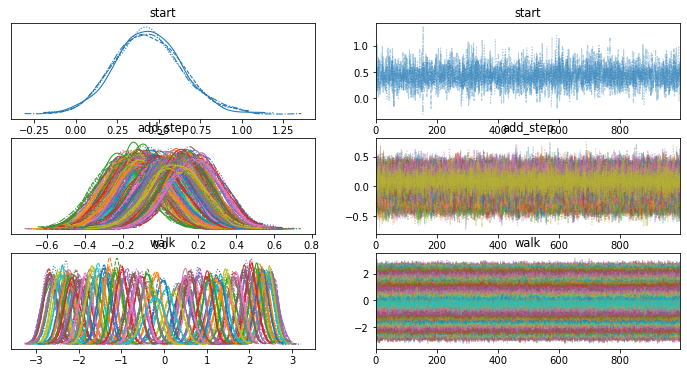

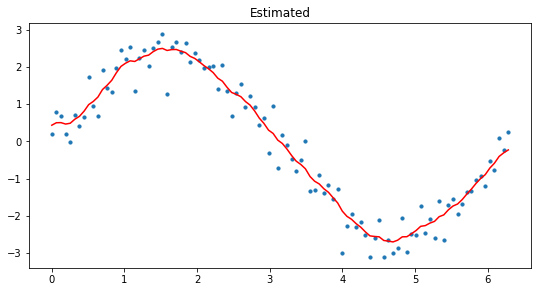

In [10]:
do_model(m3, 'Hand coded - cut down', compare)

## Using the built-in Gaussian Random Walk

In [11]:
m2 = pm.Model()
with m2:
    # priors (noting that GRW uses a flat prior on the starting point)
    innovation = pm.HalfNormal('innovation', sigma=0.1)
    walk = pm.GaussianRandomWalk('walk', mu=0, sigma=innovation, shape=len(y))
    
    sigma = pm.HalfNormal('sigma', sigma=NOISE_SD)
    nu = pm.Poisson('nu', mu=STUDENT_T_DF)
    
    # likelihood (measurement model with fat-tail noise) - use student's t distribution
    obs = pm.StudentT('obs', mu=walk, nu=nu, sigma=sigma, observed=y)

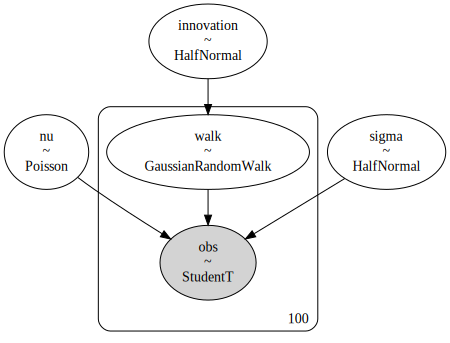

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, walk, innovation]
>Metropolis: [nu]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


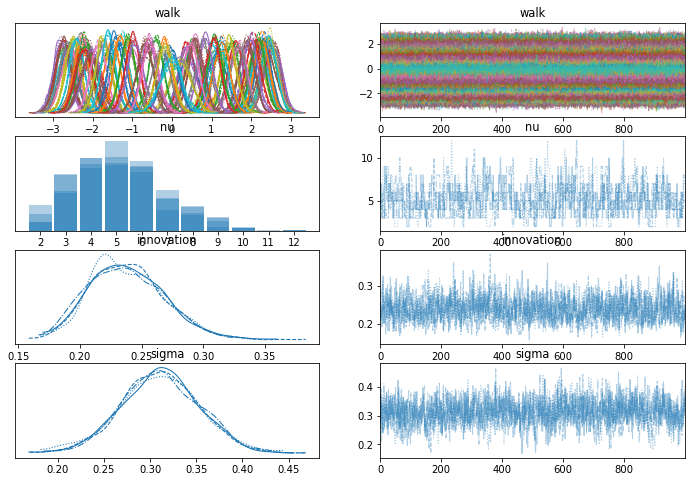

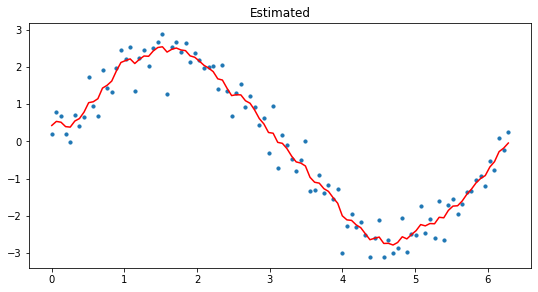

In [12]:
do_model(m2, 'Using full built-in GRW', compare)

## Built-in GRW - with a cut down model

In [13]:
m4 = pm.Model()
with m4:
    # priors (noting that GRW uses a flat prior on the starting point)
    walk = pm.GaussianRandomWalk('walk', mu=0, sigma=INNOVATION, shape=len(y))
    
    # likelihood (measurement model with fat-tail noise) - use student's t distribution
    obs = pm.StudentT('obs', mu=walk, nu=STUDENT_T_DF, sigma=NOISE_SD, observed=y)

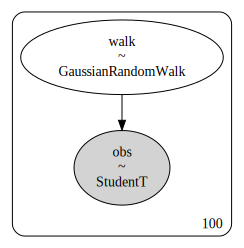

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [walk]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 34 seconds.


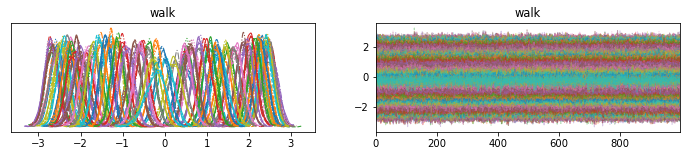

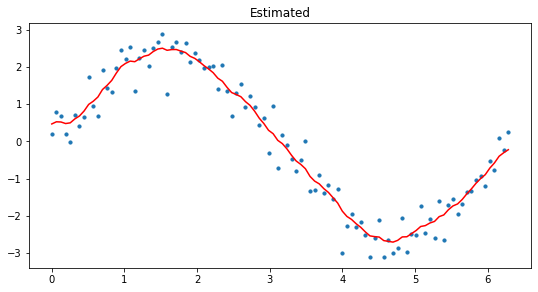

In [14]:
do_model(m4, 'Using built-in GRW - cut down model', compare)

## Comparison plot

Hand coded - full version: 100
Hand coded - cut down: 100
Using full built-in GRW: 100
Using built-in GRW - cut down model: 100


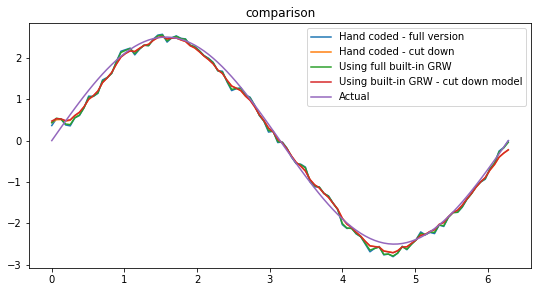

In [15]:
fig, ax = plt.subplots(figsize=(9, 4.5))
for label, series in compare.items():
    print(f'{label}: {len(series)}')
    ax.plot(x, series, label=label)
ax.plot(x, actual, label='Actual')
ax.set_title('comparison')
ax.legend(loc='best')
plt.show()
plt.close()

## Observations

* Looks like the hand coded and built-in Gaussian Random Walk yield the same results with the same parameters and same effective model. 
* However, the built-in version runs faster. 
* The built-in version is less problematic (rhat, ess, divergences, etc.)